Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import SwitchingCoordination as sc
import numpy as np
from tqdm import tqdm

import multiprocessing
num_processors = multiprocessing.cpu_count()
print("Number of processors:", num_processors)

from importlib import reload
reload(sc)
# %load_ext autoreload
# %autoreload 2

Number of processors: 16


<module 'SwitchingCoordination' from '/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py'>

Define the parameters 

In [2]:
# simulation parameters
N = 3
ref_time = 5.0
noise_std = 0.5
avg_frequency = 0.0
write_file = False # True


# monte-carlo parameters
n_mc_reps = 5


[deprecated] Running the parameter scanning

In [8]:
# Define the array of the scanning parameter
switching_rate_arr = np.arange(start = 0, stop = 0.5, step = 0.01)

# make an empty out_data to fill in later
out_data = {}
out_data_list = []

# monte-carlo loop
for i_switching_rate, switching_rate in enumerate(tqdm(switching_rate_arr)):

    # initialize a parameter dictionary
    params = sc.InitParams(N=N,switchingRate=switching_rate,
                        refTime=ref_time,noiseStd=noise_std,
                        avgFrequency=avg_frequency, writeFile=write_file)
    
    # repeat single simulation for "n_mc_reps" times
    for mc_iter in np.arange(n_mc_reps):
        
        #perform a single simulation
        out_data_tmp = sc.SingleSimulation(params)

        # make an empty (temporary) dict to put all the data (params + output) into
        tmp_dict = {}
        # put the params into the dict
        for key, val in dict.items(params):
            tmp_dict[key] = val
        # put the time and order arrays into the dict
        tmp_dict['t'] = np.array(out_data_tmp[0]['t'])
        tmp_dict['order'] = np.array(out_data_tmp[0]['order'])
        tmp_dict["mc_iter"] = mc_iter

        # append it to the list 
        out_data_list.append(tmp_dict)

# convert it to a pd.df
out_data_df = pd.DataFrame(out_data_list)

100%|██████████| 50/50 [00:05<00:00,  9.21it/s]


New param scan, with dict

In [5]:
# make an empty out_data to fill in later
out_data = {}
out_data_list = []

param_scan_dict = {"switchingRate": {"range": np.logspace(0,1,10), "log": True},
                   "N": {"range": np.linspace(3,15,5), "log": False}}

# initialize a parameter dictionary
params = sc.InitParams(N=-1,switchingRate=-1,
                            refTime=ref_time,noiseStd=noise_std,
                            avgFrequency=avg_frequency, writeFile=write_file,showAnimation=False)

# first parameters loop
for i_switching_rate, switching_rate in enumerate(tqdm(param_scan_dict['switchingRate']['range'])):
    params['switchingRate'] = switching_rate

    # second parameter loop
    for i_N, N in enumerate(tqdm(param_scan_dict['N']['range'])):
        params['N'] = int(N)

        # MonteCarlo Loop
        # repeat single simulation for "n_mc_reps" times
        for mc_iter in np.arange(n_mc_reps):
            
            #perform a single simulation
            out_data_tmp = sc.SingleSimulation(params)

            # make an empty (temporary) dict to put all the data (params + output) into
            tmp_dict = {}
            # put the params into the dict
            for key, val in dict.items(params):
                tmp_dict[key] = val
            # put the time and order arrays into the dict
            tmp_dict['t'] = np.array(out_data_tmp[0]['t'])
            tmp_dict['order'] = np.array(out_data_tmp[0]['order'])
            tmp_dict["mc_iter"] = mc_iter

            # append it to the list 
            out_data_list.append(tmp_dict)

    # convert it to a pd.df
    out_data_df = pd.DataFrame(out_data_list)

100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


New param scan, with dict and multi-processing

In [6]:
# make an empty out_data to fill in later
out_data = {}
out_data_list = []

param_scan_dict = {"switchingRate": {"range": np.logspace(0,1,10), "log": True},
                   "N": {"range": np.linspace(3,15,5), "log": False}}

# initialize a parameter dictionary
params = sc.InitParams(N=-1,switchingRate=-1,
                            refTime=ref_time,noiseStd=noise_std,
                            avgFrequency=avg_frequency, writeFile=write_file,showAnimation=False)

def perform_parameter_scan(params):
    print(params)
    # Create a multiprocessing pool with the desired number of processes
    pool = multiprocessing.Pool(processes=num_processors)
    # Map the simulate function to the parameters using the multiprocessing pool
    out_data_tmp = pool.map(sc.SingleSimulation, params)

    # Close the pool and wait for the processes to finish
    pool.close()
    pool.join()

    # make an empty (temporary) dict to put all the data (params + output) into
    tmp_dict = {}
    # put the params into the dict
    for key, val in dict.items(params):
        tmp_dict[key] = val
    # put the time and order arrays into the dict
    tmp_dict['t'] = np.array(out_data_tmp[0]['t'])
    tmp_dict['order'] = np.array(out_data_tmp[0]['order'])
    tmp_dict["mc_iter"] = mc_iter

    # append it to the list 
    out_data_list.append(tmp_dict)



# first parameters loop
for i_switching_rate, switching_rate in enumerate(tqdm(param_scan_dict['switchingRate']['range'])):
    params['switchingRate'] = switching_rate

    # second parameter loop
    for i_N, N in enumerate(tqdm(param_scan_dict['N']['range'])):
        params['N'] = int(N)

        # MonteCarlo Loop
        # repeat single simulation for "n_mc_reps" times

        # Create and start processes for parameter scanning
        processes = []
        for mc_iter in np.arange(n_mc_reps):
            process = multiprocessing.Process(target=perform_parameter_scan, kwargs={"params":params})
            processes.append(process)
            process.start()

        # Wait for all processes to finish
        for process in processes:
            process.join()



  0%|          | 0/10 [00:00<?, ?it/s]

{'N': 3, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.0, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 3, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.0, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 3, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.0, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 3, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.0, 'refTime': 5

Process Process-251:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""
Process Process-253:

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, *

{'N': 6, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.0, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 6, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.0, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 6, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.0, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}{'N': 6, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.0, 'refTime': 5.

Process Process-256:
Process Process-257:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target

{'N': 9, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.0, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 9, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.0, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 9, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.0, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 9, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.0, 'refTime': 5

Process Process-261:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""

The above exception was the direct cause of the following exception:

Process Process-262:
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target

{'N': 12, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.0, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 12, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.0, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 12, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.0, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 12, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.0, 'refTime

Process Process-266:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
Process Process-267:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, *

{'N': 15, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.0, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 15, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.0, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 15, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.0, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 15, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.0, 'refTime

Process Process-271:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self.

{'N': 3, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.2915496650148839, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 3, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.2915496650148839, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 3, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.2915496650148839, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 3, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388

Process Process-280:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
Process Process-279:
Process Process-276:
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in

{'N': 6, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.2915496650148839, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 6, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.2915496650148839, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 6, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.2915496650148839, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 6, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388

Process Process-281:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self.

{'N': 9, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.2915496650148839, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 9, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.2915496650148839, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 9, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.2915496650148839, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 9, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388

Process Process-287:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""

The above exception was the direct cause of the following exception:

Process Process-286:
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/us

{'N': 12, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.2915496650148839, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 12, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.2915496650148839, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 12, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.2915496650148839, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 12, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.1581

Process Process-291:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self.

{'N': 15, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.2915496650148839, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 15, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.2915496650148839, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 15, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.2915496650148839, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 15, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.1581

Process Process-296:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""
Process Process-298:
Process Process-297:

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result =

{'N': 3, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.6681005372000588, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 3, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.6681005372000588, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 3, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.6681005372000588, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 3, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388

Process Process-303:
Process Process-302:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""

The above exception was the direct cause of the following exception:

Process Process-301:
Traceback (most recent call last):
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result =

{'N': 6, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.6681005372000588, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 6, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.6681005372000588, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 6, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.6681005372000588, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 6, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388

Process Process-306:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""
Process Process-307:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args

{'N': 9, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.6681005372000588, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 9, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.6681005372000588, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 9, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.6681005372000588, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 9, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388

Process Process-311:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Process Process-313:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/us

{'N': 12, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.6681005372000588, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 12, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.6681005372000588, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 12, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.6681005372000588, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 12, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.1581

Process Process-317:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""
Process Process-316:

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, *

{'N': 15, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.6681005372000588, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 15, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.6681005372000588, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 15, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 1.6681005372000588, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 15, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.1581

Process Process-321:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
Process Process-323:
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Process Process-325:
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in

{'N': 3, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 2.154434690031884, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 3, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 2.154434690031884, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}{'N': 3, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 2.154434690031884, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}

{'N': 3, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300

Process Process-326:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self.

{'N': 6, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 2.154434690031884, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 6, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 2.154434690031884, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 6, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 2.154434690031884, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 6, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300

Process Process-331:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self.

{'N': 9, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 2.154434690031884, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 9, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 2.154434690031884, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 9, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 2.154434690031884, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 9, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300

Process Process-336:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""
Process Process-337:

The above exception was the direct cause of the following exception:

multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/

{'N': 12, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 2.154434690031884, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 12, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 2.154434690031884, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 12, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 2.154434690031884, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 12, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.1581138

Process Process-341:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""
Process Process-342:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args

{'N': 15, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 2.154434690031884, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 15, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 2.154434690031884, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 15, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 2.154434690031884, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 15, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.1581138

Process Process-346:
Process Process-350:
Process Process-349:
Process Process-347:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", lin

{'N': 3, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 2.7825594022071245, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 3, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 2.7825594022071245, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 3, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 2.7825594022071245, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 3, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388

Process Process-351:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""
Process Process-352:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args

{'N': 6, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 2.7825594022071245, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 6, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 2.7825594022071245, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 6, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 2.7825594022071245, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 6, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388

Process Process-356:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""
Process Process-357:

The above exception was the direct cause of the following exception:

multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/

{'N': 9, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 2.7825594022071245, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 9, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 2.7825594022071245, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 9, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 2.7825594022071245, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 9, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388

Process Process-362:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self.

{'N': 12, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 2.7825594022071245, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 12, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 2.7825594022071245, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 12, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 2.7825594022071245, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 12, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.1581

Process Process-366:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self.

{'N': 15, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 2.7825594022071245, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 15, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 2.7825594022071245, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 15, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 2.7825594022071245, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 15, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.1581

Process Process-373:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self.

{'N': 3, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 3.5938136638046276, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 3, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 3.5938136638046276, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 3, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 3.5938136638046276, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 3, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388

Process Process-376:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Process Process-377:
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target

{'N': 6, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 3.5938136638046276, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 6, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 3.5938136638046276, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 6, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 3.5938136638046276, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 6, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388

Process Process-381:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Process Process-383:
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target

{'N': 9, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 3.5938136638046276, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 9, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 3.5938136638046276, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 9, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 3.5938136638046276, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 9, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388

Process Process-386:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""

The above exception was the direct cause of the following exception:

Process Process-389:
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/us

{'N': 12, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 3.5938136638046276, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 12, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 3.5938136638046276, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 12, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 3.5938136638046276, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 12, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.1581

Process Process-393:
Process Process-392:
Process Process-391:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""

The above exception was the direct cause of the following exception:

multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File

{'N': 15, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 3.5938136638046276, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 15, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 3.5938136638046276, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 15, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 3.5938136638046276, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 15, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.1581

Process Process-396:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""
Process Process-397:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args

{'N': 3, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 4.641588833612778, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 3, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 4.641588833612778, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 3, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 4.641588833612778, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 3, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300

Process Process-401:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self.

{'N': 6, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 4.641588833612778, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 6, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 4.641588833612778, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 6, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 4.641588833612778, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 6, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300

Process Process-406:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self.

{'N': 9, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 4.641588833612778, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 9, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 4.641588833612778, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 9, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 4.641588833612778, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 9, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300

Process Process-411:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
Process Process-412:
Process Process-414:
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent ca

{'N': 12, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 4.641588833612778, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 12, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 4.641588833612778, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 12, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 4.641588833612778, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 12, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.1581138

Process Process-418:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""
Process Process-416:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args

{'N': 15, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 4.641588833612778, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 15, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 4.641588833612778, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 15, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 4.641588833612778, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}{'N': 15, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388

Process Process-421:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self.

{'N': 3, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 5.994842503189409, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 3, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 5.994842503189409, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 3, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 5.994842503189409, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 3, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300

Process Process-426:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""
Process Process-427:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args

{'N': 6, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 5.994842503189409, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 6, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 5.994842503189409, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 6, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 5.994842503189409, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 6, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300

Process Process-431:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""
Process Process-433:

The above exception was the direct cause of the following exception:

multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/

{'N': 9, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 5.994842503189409, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 9, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 5.994842503189409, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 9, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 5.994842503189409, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 9, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300

Process Process-437:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""
Process Process-436:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args

{'N': 12, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 5.994842503189409, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 12, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 5.994842503189409, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 12, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 5.994842503189409, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 12, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.1581138

Process Process-441:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self.

{'N': 15, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 5.994842503189409, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 15, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 5.994842503189409, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 15, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 5.994842503189409, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}{'N': 15, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388

Process Process-446:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
Process Process-447:
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/us

{'N': 3, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 7.742636826811269, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 3, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 7.742636826811269, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 3, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 7.742636826811269, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 3, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300

Process Process-451:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Process Process-452:
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target

{'N': 6, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 7.742636826811269, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 6, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 7.742636826811269, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 6, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 7.742636826811269, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 6, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300

Exception ignored in: <function _releaseLock at 0x7fb02cc02e50>
Traceback (most recent call last):
  File "/usr/lib/python3.8/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


{'N': 6, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 7.742636826811269, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}


Process Process-456:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self.

{'N': 9, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 7.742636826811269, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 9, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 7.742636826811269, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 9, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 7.742636826811269, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 9, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300

Process Process-461:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self.

{'N': 12, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 7.742636826811269, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 12, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 7.742636826811269, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 12, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 7.742636826811269, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 12, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.1581138

Process Process-468:
Process Process-466:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""
Process Process-467:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    

{'N': 15, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 7.742636826811269, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 15, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 7.742636826811269, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 15, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 7.742636826811269, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 15, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.1581138

Process Process-471:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Process Process-472:
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target

{'N': 3, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 10.0, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 3, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 10.0, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 3, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 10.0, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 3, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 10.0, 'refTime

Process Process-476:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self.

{'N': 6, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 10.0, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 6, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 10.0, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 6, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 10.0, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 6, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 10.0, 'refTime

Process Process-481:

The above exception was the direct cause of the following exception:

Process Process-482:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""

The above exception was the direct cause of the following exception:

multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in work

{'N': 9, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 10.0, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 9, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 10.0, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 9, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 10.0, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 9, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 10.0, 'refTime

Process Process-486:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""
Process Process-487:

The above exception was the direct cause of the following exception:

multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/

{'N': 12, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 10.0, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 12, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 10.0, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 12, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 10.0, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 12, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 10.0, 'ref

Process Process-495:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self.

{'N': 15, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 10.0, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 15, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 10.0, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 15, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 10.0, 'refTime': 5.0, 'avgFrequency': 0.0, 'stdFrequency': 0.0, 'dt': 0.1, 'simTime': 100.0, 'simSteps': 1000, 'outTime': 1.0, 'outStep': 10, 'writeFile': False, 'showAnimation': False}
{'N': 15, 'couplingStrength': 1.0, 'noiseStd': 0.5, 'noiseAmplitude': 0.15811388300841897, 'switchingRate': 10.0, 'ref

Process Process-496:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 175, in SingleSimulation
    #initialize data if not passed to function
  File "/home/mohsen/Project/colab/sara_Pujiula_BSc_thesis/codes/switching_coordination/SwitchingCoordination.py", line 38, in InitData
TypeError: string indices must be integers
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self.

In [ ]:
params['N']

15

In [ ]:
# param_scan_dict = {"switch_rate": {"begin": 0.1, "end": 0.5, "bins": 5, "log": False},
                    # "N": {"begin": 3, "end": 15, "bins": 5, "log": False}}

import numpy as np
param_scan_dict = {"switch_rate": {"range": np.logspace(0,1,10), "log": True},
                    "N": {"range": np.linspace(0,1,10), "log": False}}


In [ ]:
for item in param_scan_dict.items():
    print(item[1]["range"])

[ 1.          1.29154967  1.66810054  2.15443469  2.7825594   3.59381366
  4.64158883  5.9948425   7.74263683 10.        ]
[0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]


In [ ]:
# type(out_data_df)
out_data_df.loc[0]

N                                                                   3
couplingStrength                                                  1.0
noiseStd                                                          0.5
noiseAmplitude                                               0.158114
switchingRate                                                     0.0
refTime                                                           5.0
avgFrequency                                                      0.0
stdFrequency                                                      0.0
dt                                                                0.1
simTime                                                         100.0
simSteps                                                         1000
outTime                                                           1.0
outStep                                                            10
writeFile                                                       False
t                   

Plot a single run data

Text(0.2, 0.1, 'avg order = 0.951')

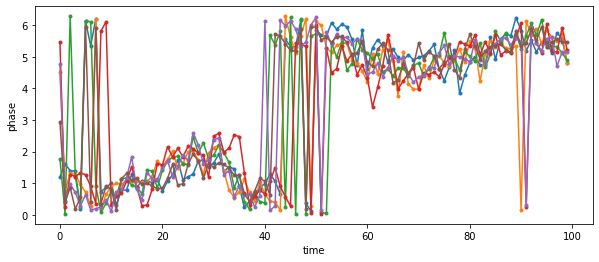

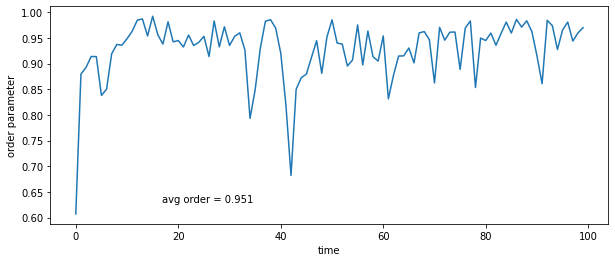

In [ ]:
switching_rate_index_to_plot = 0
mc_iter_to_plot = 0

out_data_to_plot = out_data[switching_rate_index_to_plot, mc_iter_to_plot]

# plot single trajectories versus time
plt.figure(figsize=(10,4))
plt.plot(out_data_to_plot['t'],(out_data_to_plot['phi']),'.-')
plt.xlabel('time')
plt.ylabel('phase')
#plot order parameter versus time
plt.figure(figsize=(10,4))
ax=plt.subplot()
plt.plot(out_data_to_plot['t'],out_data_to_plot['order'])
plt.xlabel('time')
plt.ylabel('order parameter')
avg_order=np.mean(out_data_to_plot['order'][-25:])
plt.text(0.2,0.1,'avg order = %.3f' % avg_order,transform=ax.transAxes)

Calculate the average order of the monte-carlo simulations

In [ ]:
avg_order = np.empty(shape=(len(switching_rate_arr),n_mc_reps))
for i_switching_rate in np.arange(len(switching_rate_arr)):
    for mc_iter in np.arange(n_mc_reps):
        out_data_tmp = out_data[i_switching_rate, mc_iter]
        avg_order_tmp = np.mean(out_data_tmp['order'][-25:])
        avg_order[i_switching_rate, mc_iter] = avg_order_tmp

# calculate the mean of the average order over monte-carlo reps.
avg_order_over_reps = np.mean(avg_order, axis=1)

Plot the average vs scanning parameter

Text(0, 0.5, 'average order')

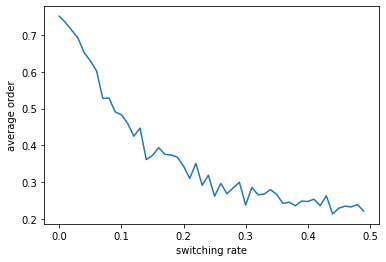

In [ ]:
plt.plot(switching_rate_arr, avg_order_over_reps)
plt.xlabel("switching rate")
plt.ylabel("average order")